#**All General Imports**

In [20]:
import os
import timeit
import platform
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

#**All Tensorflow 2.x Imports**

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

#**All Functions Definitions**

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  '''
  Convert series to supervised learning
  '''
  
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  agg = concat(cols, axis=1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace=True)
  return agg
 
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

#**All Data Downloads**

In [12]:
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

out = data_download("./Series_Data", "1q7EJqJ8zYdJkSRE3NceSnJTCbCOXeOzp", OS)
print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  9.705083182999942


#**Data Preprocessing**

In [13]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


#**Train Test Split**

In [15]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


#**Model Definition**

In [16]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Epoch 1/50


KeyboardInterrupt: ignored

#**Model Training**

In [17]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 2s - loss: 0.0381 - val_loss: 0.0612 - 2s/epoch - 18ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0229 - val_loss: 0.0529 - 2s/epoch - 16ms/step
Epoch 3/50
122/122 - 3s - loss: 0.0182 - val_loss: 0.0506 - 3s/epoch - 29ms/step
Epoch 4/50
122/122 - 3s - loss: 0.0167 - val_loss: 0.0378 - 3s/epoch - 24ms/step
Epoch 5/50
122/122 - 3s - loss: 0.0156 - val_loss: 0.0267 - 3s/epoch - 26ms/step
Epoch 6/50
122/122 - 3s - loss: 0.0151 - val_loss: 0.0223 - 3s/epoch - 27ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0199 - 2s/epoch - 17ms/step
Epoch 8/50
122/122 - 3s - loss: 0.0148 - val_loss: 0.0184 - 3s/epoch - 25ms/step
Epoch 9/50
122/122 - 3s - loss: 0.0148 - val_loss: 0.0175 - 3s/epoch - 25ms/step
Epoch 10/50
122/122 - 3s - loss: 0.0148 - val_loss: 0.0164 - 3s/epoch - 26ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0155 - 1s/epoch - 10ms/step
Epoch 12/50
122/122 - 2s - loss: 0.0147 - val_loss: 0.0141 - 2s/epoch - 13ms/step
Epoch 13/50
122/122 - 1s 

#**History Plot**

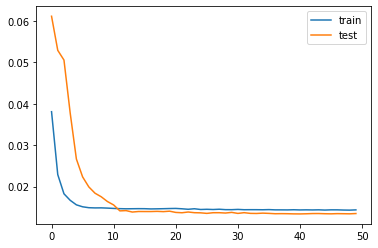

In [18]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#**Model Testing**

In [21]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

#**Homeworks**

1) Train a Time Series Model for predicting Bitcoin time series: train the model on poloniex_storico.csv which is the time series of BTC/ETH pairs. Predict the close value

2) Make the best model with callbacks and more comple LSTM models

3) Plot the predictions